# Property Price Estimation

In [56]:
import time                      # Import libraries
start_time = time.time()

import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

from sklearn.preprocessing import StandardScaler      # Import sklearn libraries
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from xgboost import XGBRegressor                     # Import few powerful Regressor Libraries
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor


In [57]:
loading_a_pickle_file = pickle.load(open("./DATA/house_df.pkl", "rb"))
loading_a_pickle_file.head()
df = shuffle(loading_a_pickle_file)

In [58]:
df.isnull().sum().sum()   # Check if there is any Nan in the dataframe

0

In [59]:
df.duplicated().sum()    # Check for duplication

0

In [60]:
#Splitting train and test sets
house_train, house_test = train_test_split(df, test_size=0.25, random_state=42)
print(house_train.shape)
print(house_test.shape)

(1042, 110)
(348, 110)


In [61]:
#Splitting train and validation sets
house_train, house_val = train_test_split(house_train, test_size=0.25, random_state=42)
print(house_train.shape)
print(house_val.shape)

(781, 110)
(261, 110)


In [62]:
df.describe() # check the description of all the numeric features(which are all the features)

,TotalBsmtSFSqrt,OpenPorchSFLog,MasVnrAreaSqrt,YearRemodAdd,FirstFlrSFLog,GrLivAreaLog,LotAreaSqrt,YearBuilt,SalePriceLog,KitchenQual_Ex,...,MSZoning_RH,MSZoning_RL,MSZoning_RM,PavedDrive_N,PavedDrive_P,PavedDrive_Y,Fireplaces_0,Fireplaces_1,Fireplaces_2,Fireplaces_3
count,1390.000000,1390.000000,1390.000000,1390.000000,1390.000000,1390.000000,1390.000000,1390.000000,1390.000000,1390.000000,...,1390.000000,1390.000000,1390.000000,1390.000000,1390.000000,1390.000000,1390.000000,1390.000000,1390.000000,1390.000000
mean,31.387210,-4.029443,6.019169,1985.015827,6.998242,7.258338,95.906207,1971.672662,12.021953,0.064748,...,0.011511,0.789928,0.150360,0.058273,0.021583,0.920144,0.478417,0.450360,0.068345,0.002878
std,7.535796,8.967297,8.075006,20.555876,0.309415,0.324334,20.186159,29.942422,0.377492,0.246170,...,0.106707,0.407506,0.357552,0.234344,0.145369,0.271168,0.499714,0.497709,0.252428,0.053586
min,0.000000,-13.815511,0.000000,1950.000000,5.811141,5.811141,36.055513,1872.000000,10.471950,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,28.178006,-13.815511,0.000000,1967.000000,6.777076,7.025538,86.481183,1954.000000,11.775290,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,31.344855,3.178054,0.000000,1994.000000,6.982399,7.283448,96.757428,1973.000000,11.996892,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,35.619517,4.189655,12.806248,2004.000000,7.221105,7.476189,106.591510,2000.750000,12.264342,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000
max,56.621551,5.897154,40.000000,2010.000000,8.079618,8.158516,186.145105,2010.000000,13.275828,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [63]:
#Function to split features from Label
def split_features_labels(dataframe_name,label):
    Y_ = pd.DataFrame(dataframe_name[[label]])
    X_ = dataframe_name.drop([label], axis=1)
    return(X_,Y_)

In [64]:
#Separating the features from the Sale Price
X_train, Y_train = split_features_labels(house_train,"SalePriceLog")
X_val, Y_val = split_features_labels(house_val,"SalePriceLog")
X_test, Y_test = split_features_labels(house_test,"SalePriceLog")

In [65]:
scalar = StandardScaler()   # Standardising all the numerical features in traning dataframe
X_train = scalar.fit_transform(X_train)

 #  Standardising all the numerical features in validation dataframe
X_val = scalar.fit_transform(X_val)

 #  Standardising all the numerical features in test dataframe
X_test = scalar.fit_transform(X_test)

In [92]:
df_train = pd.DataFrame(X_train, copy = True)  # Creating a training dataframe with all the features and label
df_train["SalePriceLog"]=Y_train


In [116]:
corr_matrix = df_train.corr()
print(corr_matrix[5]["SalePriceLog"])
print(len(corr_matrix))
for i in range(len(corr_matrix)-1):
    if corr_matrix[i]["SalePriceLog"] > 0.01:
        print(i, ":", corr_matrix[i]["SalePriceLog"])

0.03985708317954099
110
2 : 0.02093586294156442
3 : 0.04295105942389862
5 : 0.03985708317954099
6 : 0.03601536072860587
7 : 0.08153260750462038
8 : 0.06409894068094582
10 : 0.02296576595223558
12 : 0.0786005905193324
13 : 0.02386139523372641
14 : 0.06780605323210315
19 : 0.049841220261851935
20 : 0.06984597083267992
22 : 0.030822892588041027
28 : 0.05594609548975095
30 : 0.018580549691133746
31 : 0.02811466279531624
33 : 0.0260166150588953
35 : 0.020021967918532047
37 : 0.010098884615694853
38 : 0.05679836862644798
40 : 0.024879401836085988
41 : 0.026980697773781252
43 : 0.014362520495938046
44 : 0.08651869699829597
45 : 0.031815028657583115
46 : 0.04160101319264992
50 : 0.11615946104953047
51 : 0.07860059051933206
56 : 0.03682824922809961
57 : 0.06810036494636183
59 : 0.049849385870662496
60 : 0.02137328893330829
62 : 0.045072023449073496
63 : 0.027192355662788034
69 : 0.06311385879054601
72 : 0.010079792969850369
73 : 0.10084349594432802
77 : 0.06630064971879564
79 : 0.02130266231316

Text(5, 0, 'Correlation Heatmap of House Price Dataframe')

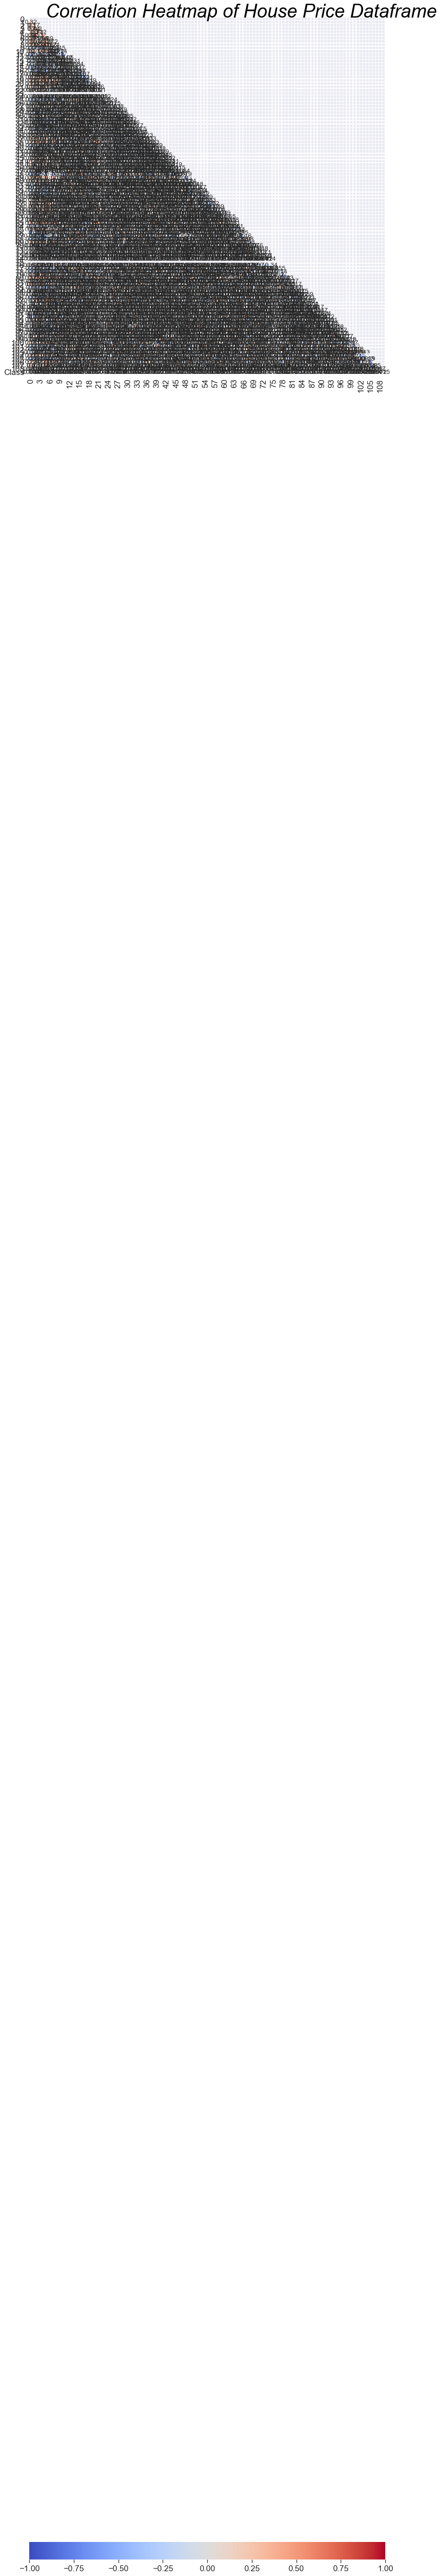

In [80]:
sns.set_theme(style="white")
sns.set(font_scale=1.4)
# Compute the correlation matrix
corr = df_train.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Setup the matplotlib figure
f, ax = plt.subplots(figsize=(12, 500))
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap='coolwarm', vmax=1,vmin=-1, center=0, annot=True, annot_kws={"size": 12}, fmt='.2g',square=True, linewidths=.3,cbar_kws= {'orientation': 'horizontal'})
plt.text(5,0, "Correlation Heatmap of House Price Dataframe", fontsize = 35, color='Black', fontstyle='italic')

array([[ 1.23417573,  0.77031273, -0.72152118, ..., -0.87549841,
        -0.29002095, -0.09325048],
       [-0.04687321,  0.88019185, -0.72152118, ..., -0.87549841,
        -0.29002095, -0.09325048],
       [ 0.8154063 ,  0.77488589,  0.67891151, ..., -0.87549841,
        -0.29002095, -0.09325048],
       ...,
       [ 0.85792827,  0.80598807,  1.46960781, ...,  1.14220653,
        -0.29002095, -0.09325048],
       [ 0.24632062,  1.01005741,  1.40787345, ..., -0.87549841,
         3.44802681, -0.09325048],
       [ 0.35118663,  0.87842762, -0.72152118, ..., -0.87549841,
        -0.29002095, -0.09325048]])

In [15]:
#Predicting using RandomForest
randomforestregressor = RandomForestRegressor(n_estimators = 100, max_features = 8,max_depth = 10)
randomforestregressor.fit(X_train, Y_train)
Y_prediction = randomforestregressor.predict(X_test)

Y_test["SalePricePred"] = Y_prediction
print("{}".format(round(np.exp(Y_test),-2)/1000))

#Pred_df = Pred_df.rename(columns={0: "SalePriceLog"})

print("Correlation : ", round((Y_test["SalePricePred"].corr(Y_test["SalePriceLog"]))*100,2), "%")

C:\Users\AICORE\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


     SalePriceLog  SalePricePred
582         118.5          130.2
172         239.0          195.8
248         180.0          205.2
697         123.5          133.8
281         185.0          186.1
..            ...            ...
972          99.5          140.6
544         179.7          192.2
477         380.0          361.4
514          96.5          107.3
343         266.0          287.7

[348 rows x 2 columns]
Correlation :  95.62 %


In [16]:
# Calculating the rate average rate of error(%)
percentage_error = 0
for _ , row in Y_test.iterrows():
    percentage_error += np.abs(100*(np.exp(row["SalePricePred"])-np.exp(row["SalePriceLog"]))/np.exp(row["SalePriceLog"]))
print("Average error is {}%".format(round(percentage_error/len(Y_test),2)))

Average error is 9.11%


In [17]:

xg_reg = XGBRegressor( learning_rate = 0.1,
                max_depth = 10, n_estimators = 100)

xg_reg.fit(X_train,Y_train)
preds = xg_reg.predict(X_test)
Y_test["SalePricePred"] = preds
print("{}".format(round(np.exp(Y_test),-2)/1000))
print("Correlation : ", round((Y_test["SalePricePred"].corr(Y_test["SalePriceLog"]))*100,2), "%")



     SalePriceLog  SalePricePred
582         118.5          112.6
172         239.0          204.9
248         180.0          199.7
697         123.5          117.9
281         185.0          189.0
..            ...            ...
972          99.5          135.7
544         179.7          182.0
477         380.0          386.5
514          96.5          112.3
343         266.0          309.5

[348 rows x 2 columns]
Correlation :  95.55 %


In [18]:
# Calculating the rate average rate of error(%)
percentage_error = 0
for _ , row in Y_test.iterrows():
    percentage_error += np.abs(100*(np.exp(row["SalePricePred"])-np.exp(row["SalePriceLog"]))/np.exp(row["SalePriceLog"]))
print("Average error is {}%".format(round(percentage_error/len(Y_test),2)))

Average error is 8.46%


In [19]:

ct_reg = CatBoostRegressor( learning_rate = 0.1,
                max_depth = 10, n_estimators = 1000)

ct_reg.fit(X_train,Y_train)
preds = ct_reg.predict(X_test)
Y_test["SalePricePred"] = preds
print("{}".format(round(np.exp(Y_test),-2)/1000))
print("Correlation : ", round((Y_test["SalePricePred"].corr(Y_test["SalePriceLog"]))*100,2), "%")



0:	learn: 0.3514097	total: 261ms	remaining: 4m 21s
1:	learn: 0.3290067	total: 279ms	remaining: 2m 19s
2:	learn: 0.3078419	total: 313ms	remaining: 1m 44s
3:	learn: 0.2888957	total: 347ms	remaining: 1m 26s
4:	learn: 0.2731339	total: 381ms	remaining: 1m 15s
5:	learn: 0.2585606	total: 415ms	remaining: 1m 8s
6:	learn: 0.2451730	total: 452ms	remaining: 1m 4s
7:	learn: 0.2313336	total: 492ms	remaining: 1m 1s
8:	learn: 0.2197942	total: 527ms	remaining: 58.1s
9:	learn: 0.2088023	total: 561ms	remaining: 55.5s
10:	learn: 0.1996491	total: 594ms	remaining: 53.4s
11:	learn: 0.1905932	total: 635ms	remaining: 52.3s
12:	learn: 0.1825619	total: 686ms	remaining: 52.1s
13:	learn: 0.1757764	total: 725ms	remaining: 51s
14:	learn: 0.1686560	total: 760ms	remaining: 49.9s
15:	learn: 0.1625187	total: 807ms	remaining: 49.6s
16:	learn: 0.1571371	total: 845ms	remaining: 48.9s
17:	learn: 0.1521214	total: 887ms	remaining: 48.4s
18:	learn: 0.1477751	total: 935ms	remaining: 48.3s
19:	learn: 0.1433546	total: 972ms	rema

163:	learn: 0.0461146	total: 6.35s	remaining: 32.4s
164:	learn: 0.0457022	total: 6.39s	remaining: 32.3s
165:	learn: 0.0455870	total: 6.43s	remaining: 32.3s
166:	learn: 0.0452047	total: 6.46s	remaining: 32.2s
167:	learn: 0.0448323	total: 6.5s	remaining: 32.2s
168:	learn: 0.0445514	total: 6.54s	remaining: 32.1s
169:	learn: 0.0442975	total: 6.57s	remaining: 32.1s
170:	learn: 0.0440756	total: 6.62s	remaining: 32.1s
171:	learn: 0.0437616	total: 6.65s	remaining: 32s
172:	learn: 0.0435946	total: 6.69s	remaining: 32s
173:	learn: 0.0434232	total: 6.73s	remaining: 32s
174:	learn: 0.0431526	total: 6.77s	remaining: 31.9s
175:	learn: 0.0429213	total: 6.81s	remaining: 31.9s
176:	learn: 0.0426335	total: 6.84s	remaining: 31.8s
177:	learn: 0.0423925	total: 6.88s	remaining: 31.8s
178:	learn: 0.0422499	total: 6.92s	remaining: 31.7s
179:	learn: 0.0421119	total: 6.96s	remaining: 31.7s
180:	learn: 0.0416795	total: 7s	remaining: 31.7s
181:	learn: 0.0414833	total: 7.03s	remaining: 31.6s
182:	learn: 0.0411191	

324:	learn: 0.0211496	total: 12.4s	remaining: 25.9s
325:	learn: 0.0211281	total: 12.5s	remaining: 25.8s
326:	learn: 0.0210717	total: 12.5s	remaining: 25.8s
327:	learn: 0.0210397	total: 12.6s	remaining: 25.7s
328:	learn: 0.0210082	total: 12.6s	remaining: 25.7s
329:	learn: 0.0208398	total: 12.6s	remaining: 25.6s
330:	learn: 0.0208078	total: 12.6s	remaining: 25.5s
331:	learn: 0.0206809	total: 12.7s	remaining: 25.5s
332:	learn: 0.0205596	total: 12.7s	remaining: 25.5s
333:	learn: 0.0204991	total: 12.7s	remaining: 25.4s
334:	learn: 0.0204596	total: 12.8s	remaining: 25.4s
335:	learn: 0.0204311	total: 12.8s	remaining: 25.3s
336:	learn: 0.0203527	total: 12.9s	remaining: 25.3s
337:	learn: 0.0202815	total: 12.9s	remaining: 25.3s
338:	learn: 0.0201870	total: 12.9s	remaining: 25.2s
339:	learn: 0.0201625	total: 13s	remaining: 25.2s
340:	learn: 0.0200692	total: 13s	remaining: 25.1s
341:	learn: 0.0199899	total: 13s	remaining: 25.1s
342:	learn: 0.0199208	total: 13.1s	remaining: 25.1s
343:	learn: 0.0198

483:	learn: 0.0118898	total: 18.4s	remaining: 19.6s
484:	learn: 0.0118322	total: 18.4s	remaining: 19.6s
485:	learn: 0.0118003	total: 18.5s	remaining: 19.5s
486:	learn: 0.0117708	total: 18.5s	remaining: 19.5s
487:	learn: 0.0116940	total: 18.6s	remaining: 19.5s
488:	learn: 0.0115942	total: 18.6s	remaining: 19.4s
489:	learn: 0.0115812	total: 18.6s	remaining: 19.4s
490:	learn: 0.0115542	total: 18.7s	remaining: 19.3s
491:	learn: 0.0115366	total: 18.7s	remaining: 19.3s
492:	learn: 0.0115181	total: 18.7s	remaining: 19.3s
493:	learn: 0.0114927	total: 18.8s	remaining: 19.2s
494:	learn: 0.0114302	total: 18.8s	remaining: 19.2s
495:	learn: 0.0114120	total: 18.8s	remaining: 19.2s
496:	learn: 0.0113964	total: 18.9s	remaining: 19.1s
497:	learn: 0.0113587	total: 18.9s	remaining: 19.1s
498:	learn: 0.0113209	total: 19s	remaining: 19s
499:	learn: 0.0112486	total: 19s	remaining: 19s
500:	learn: 0.0111890	total: 19s	remaining: 19s
501:	learn: 0.0110987	total: 19.1s	remaining: 18.9s
502:	learn: 0.0110920	to

648:	learn: 0.0069500	total: 24.6s	remaining: 13.3s
649:	learn: 0.0069130	total: 24.6s	remaining: 13.3s
650:	learn: 0.0068932	total: 24.7s	remaining: 13.2s
651:	learn: 0.0068926	total: 24.7s	remaining: 13.2s
652:	learn: 0.0068760	total: 24.7s	remaining: 13.1s
653:	learn: 0.0068547	total: 24.8s	remaining: 13.1s
654:	learn: 0.0068388	total: 24.8s	remaining: 13.1s
655:	learn: 0.0068165	total: 24.9s	remaining: 13s
656:	learn: 0.0067946	total: 24.9s	remaining: 13s
657:	learn: 0.0067877	total: 24.9s	remaining: 13s
658:	learn: 0.0067717	total: 25s	remaining: 12.9s
659:	learn: 0.0067609	total: 25s	remaining: 12.9s
660:	learn: 0.0067505	total: 25s	remaining: 12.8s
661:	learn: 0.0067394	total: 25.1s	remaining: 12.8s
662:	learn: 0.0067097	total: 25.1s	remaining: 12.8s
663:	learn: 0.0066921	total: 25.2s	remaining: 12.7s
664:	learn: 0.0066777	total: 25.2s	remaining: 12.7s
665:	learn: 0.0066565	total: 25.2s	remaining: 12.7s
666:	learn: 0.0066466	total: 25.3s	remaining: 12.6s
667:	learn: 0.0066377	to

809:	learn: 0.0047901	total: 30.5s	remaining: 7.14s
810:	learn: 0.0047825	total: 30.5s	remaining: 7.11s
811:	learn: 0.0047746	total: 30.5s	remaining: 7.07s
812:	learn: 0.0047626	total: 30.6s	remaining: 7.03s
813:	learn: 0.0047551	total: 30.6s	remaining: 6.99s
814:	learn: 0.0047415	total: 30.6s	remaining: 6.95s
815:	learn: 0.0047364	total: 30.7s	remaining: 6.92s
816:	learn: 0.0047290	total: 30.7s	remaining: 6.88s
817:	learn: 0.0047228	total: 30.7s	remaining: 6.84s
818:	learn: 0.0047097	total: 30.8s	remaining: 6.8s
819:	learn: 0.0047062	total: 30.8s	remaining: 6.76s
820:	learn: 0.0046921	total: 30.9s	remaining: 6.73s
821:	learn: 0.0046867	total: 30.9s	remaining: 6.69s
822:	learn: 0.0046769	total: 30.9s	remaining: 6.65s
823:	learn: 0.0046676	total: 31s	remaining: 6.61s
824:	learn: 0.0046616	total: 31s	remaining: 6.58s
825:	learn: 0.0046529	total: 31s	remaining: 6.54s
826:	learn: 0.0046480	total: 31.1s	remaining: 6.5s
827:	learn: 0.0046409	total: 31.1s	remaining: 6.46s
828:	learn: 0.004630

970:	learn: 0.0037520	total: 36.3s	remaining: 1.08s
971:	learn: 0.0037495	total: 36.3s	remaining: 1.04s
972:	learn: 0.0037467	total: 36.3s	remaining: 1.01s
973:	learn: 0.0037402	total: 36.4s	remaining: 971ms
974:	learn: 0.0037385	total: 36.4s	remaining: 934ms
975:	learn: 0.0037267	total: 36.5s	remaining: 897ms
976:	learn: 0.0037254	total: 36.5s	remaining: 859ms
977:	learn: 0.0037197	total: 36.5s	remaining: 822ms
978:	learn: 0.0037154	total: 36.6s	remaining: 785ms
979:	learn: 0.0037107	total: 36.6s	remaining: 747ms
980:	learn: 0.0037043	total: 36.7s	remaining: 710ms
981:	learn: 0.0036937	total: 36.7s	remaining: 672ms
982:	learn: 0.0036908	total: 36.7s	remaining: 635ms
983:	learn: 0.0036829	total: 36.8s	remaining: 598ms
984:	learn: 0.0036777	total: 36.8s	remaining: 560ms
985:	learn: 0.0036747	total: 36.8s	remaining: 523ms
986:	learn: 0.0036662	total: 36.9s	remaining: 486ms
987:	learn: 0.0036640	total: 36.9s	remaining: 448ms
988:	learn: 0.0036548	total: 36.9s	remaining: 411ms
989:	learn: 

In [20]:
# Calculating the rate average rate of error(%)
percentage_error = 0
for _ , row in Y_test.iterrows():
    percentage_error += np.abs(100*(np.exp(row["SalePricePred"])-np.exp(row["SalePriceLog"]))/np.exp(row["SalePriceLog"]))
print("Average error is {}%".format(round(percentage_error/len(Y_test),2)))

Average error is 8.24%


In [21]:
lg_reg = LGBMRegressor( learning_rate = 0.05,
                max_depth = 10, n_estimators = 1000)

lg_reg.fit(X_train,Y_train)
preds = lg_reg.predict(X_test)
Y_test["SalePricePred"] = preds
print("{}".format(round(np.exp(Y_test),-2)/1000))
print("Correlation : ", round((Y_test["SalePricePred"].corr(Y_test["SalePriceLog"]))*100,2), "%")


[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
     SalePriceLog  SalePricePred
582         118.5          126.6
172         239.0          200.5
248         180.0          199.0
697         123.5          125.1
281         185.0          194.2
..            ...            ...
972          99.5          138.2
544         179.7          173.8
477         380.0          394.1
514          96.5           98.7
343         266.0          288.9

[348 rows x 2 columns]
Correlation :  95.59 %


In [22]:
# Calculating the rate average rate of error(%)
percentage_error = 0
for _ , row in Y_test.iterrows():
    percentage_error += np.abs(100*(np.exp(row["SalePricePred"])-np.exp(row["SalePriceLog"]))/np.exp(row["SalePriceLog"]))
print("Average error is {}%".format(round(percentage_error/len(Y_test),2)))

Average error is 8.6%
